In [1]:
import os, string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import Counter

In [2]:
def load_data(filename):
    # set the label type to string (to allow for 'F')
    types = {
        'Label':'str'
    }
    df = pd.read_csv(filename, dtype = types)
    return df

Note that numpy uses a biased estimator for the variance, whereas pandas and MATLAB use an unbiased estimator. To keep our results consistent with previous publications e.g. Ruske, 2017 we use numpy to calculate the standard deviation. 

For further information see:
* https://stackoverflow.com/questions/27600207/why-does-numpy-std-give-a-different-result-to-matlab-std

* https://stackoverflow.com/questions/24984178/different-std-in-pandas-vs-numpy


In [3]:
def get_threshold(df, n_std):
    
    FT = df.loc[df['Label'] == 'F']

    thr = []
    for parameter in ['FL1_280', 'FL2_280', 'FL2_370']:
        thr.append(FT[parameter].mean() + n_std * np.std(FT[parameter]))
    return thr

In [4]:
def apply_threshold(df, thr):
    temp = df.copy()
    FL_cols = ['FL1_280', 'FL2_280', 'FL2_370']
    exceed_thr = temp[FL_cols] > np.array(thr, 'float')
    idx = exceed_thr.any(axis = 'columns')
    return temp.loc[idx]

In [5]:
def tabulate_data(filelist_name, data_name, n_std):
    
    # load filelist and data frame
    filelist = pd.read_csv(filelist_name)
    df = load_data(data_name)

  
    #get the threshold
    if n_std != None:
        thr = get_threshold(df, n_std)
    
    # remove FT rows
    filelist = filelist.loc[filelist['Label'] != 'F']
    df = df.loc[df['Label'] != 'F']

    if n_std != None:
        df = apply_threshold(df, thr)

    group = df.groupby(['File_Label'])
    table = {}
    table['Sample'] = filelist['Short Name']
    table['Label'] = filelist['Label']

    
    table = pd.DataFrame(table)

    parameters = ['FL1_280', 'FL2_280', 'FL2_370', 'Size', 'AF']
    for parameter in parameters:
        table[parameter] = group[parameter].mean()
        table[parameter+'$(\sigma)$'] = group[parameter].std()

    table['N'] = group[parameter].count()
    table = table.sort_values(['Label', 'Sample'])

    table['Sample_Label'] = list(string.ascii_uppercase[:len(table)])
    
    return table

In [6]:
# adapted from 
# https://matplotlib.org/gallery/ticks_and_spines/multiple_yaxis_with_spines.html

def plot_data(table, groups, filename):
    
    plt.style.use("single.mplstyle")
    
    # reduce by the groups specified
    table = table.loc[table['Label'].isin(groups)]

    # set colors for plot
    colors = [
        '#1f77b4',
        '#ff7f0e',
        '#2ca02c',
        '#d62728',
        '#9467bd']
    
    # set up figure and axis
    fig, ax = plt.subplots()
    fig.subplots_adjust(right=0.75)
    
    par1 = ax.twinx()
    par2 = ax.twinx()
    
    # set up the plots
    n_samples = len(table)
    x = np.arange(n_samples)
    
    # plot fluorescence
    for i, FL in enumerate(['FL1_280', 'FL2_280', 'FL2_370']):
        ax.bar(x + 0.3 * i, table[FL], color = colors[i], width = 0.3, alpha = 0.7)
    
    # plot size
    par1.errorbar(x+0.3, table['Size'], table['Size$(\sigma)$'], fmt='x', color = colors[3], alpha = 0.7)
    
    # plot AF
    par2.plot(x+0.3, table['AF'], 'o', color = colors[4], alpha = 0.7)
    
    #ofset axis for second twin
    par2.spines["right"].set_position(("axes", 1.2))
    
    #set y limits
    
    # i) main plot
    all_FL = table[['FL1_280', 'FL2_280', 'FL2_370']]
    ax.set_ylim(min(all_FL.min()), max(all_FL.max())*1.1)
    
    # ii) size plot
    max_err = np.max(table['Size$(\sigma)$'])
    par1.set_ylim(0, max(table['Size'])+max_err+0.1)
    
    # set labels
    ax.set_xlabel("Sample")
    ax.set_ylabel("Fluorescent Intensity (A. U.)")
    par1.set_ylabel("Size $\mu$m")
    par2.set_ylabel("Asymmetry Factor (A. U.)")
    
    # set label colors
    par1.yaxis.label.set_color(colors[3])
    par2.yaxis.label.set_color(colors[4])
    
    # set xticks
    ax.set_xticklabels(table['Sample_Label'])
    ax.set_xticks(x+0.28)
    
    #disable tight layout
    fig.set_tight_layout(False)
    
    # create legend
    handles = []
    for i, name in enumerate(['FL1_280', 'FL2_280', 'FL2_370', 'Size', 'AF']):
        patch = mpatches.Patch(color = colors[i], label = name, alpha = 0.7)
        handles.append(patch)
    plt.legend(handles = handles, bbox_to_anchor=(0, 1.02, 1., .102),\
               loc = 3, ncol= 3, mode="expand", borderaxespad=0., frameon=False)
    
    plt.savefig(filename, dpi = 600)

# Checksums

In [7]:
for filename in ["data_2008.csv", "data_2014.csv", "data_PSL.csv"]:
    print(filename)
    data = load_data(filename)
    data = data[data['Label']!='F']
    print(data['FL1_280'].agg(["count", "sum"]))

data_2008.csv
count      82772
sum      7456321
Name: FL1_280, dtype: int64
data_2014.csv
count     22542
sum      206375
Name: FL1_280, dtype: int64
data_PSL.csv
count       39696
sum      28007832
Name: FL1_280, dtype: int64


## 2008, Fluorescent threshold of $3\sigma$

In [8]:
# parameters
params = {
    'n_std' : 3
}

In [9]:
params["filelist_name"] = 'filelist_2008.csv'
params["data_name"] = 'data_2008.csv'
table_2008_3 = tabulate_data(**params)
table_2008_3.round(2)

,Sample,Label,FL1_280,FL1_280$(\sigma)$,FL2_280,FL2_280$(\sigma)$,FL2_370,FL2_370$(\sigma)$,Size,Size$(\sigma)$,AF,AF$(\sigma)$,N,Sample_Label
3,Bacillus Atrophaeus (unw),1,93.73,46.74,62.29,36.37,63.25,44.68,1.37,0.46,7.67,3.76,1015,A
4,"Bacillus Atrophaeus (unw, dil)",1,107.10,69.92,38.80,67.12,31.51,65.15,1.06,0.69,7.42,5.11,82,B
5,Bacillus Atrophaeus (w),1,159.49,133.86,59.32,57.37,46.70,54.82,1.60,0.79,9.18,4.87,1246,C
6,"Bacillus Atrophaeus (w, dil)",1,133.73,93.52,47.59,54.36,42.78,55.78,1.52,0.77,8.94,5.65,280,D
7,Bacillus Atrophaeus Vegetative Cells (unw),1,221.56,271.91,204.19,276.81,175.54,268.82,1.07,0.42,4.96,2.20,5546,E
8,"Bacillus Atrophaeus Vegetative Cells (unw, dil)",1,134.56,70.31,90.18,67.83,64.53,58.87,0.99,0.22,6.24,3.68,1739,F
9,Bacillus Atrophaeus Vegetative Cells (w),1,212.27,154.39,29.48,44.20,12.22,33.11,1.33,0.63,6.41,3.40,1961,G
10,"Bacillus Atrophaeus Vegetative Cells (w, dil)",1,151.71,42.93,18.53,19.29,7.33,17.62,1.07,0.22,10.76,5.76,2218,H
13,E coli. (unw),1,211.90,289.15,226.10,336.43,231.75,360.29,1.15,0.53,4.83,2.16,4097,I
14,"E coli. (unw, dil)",1,139.21,93.96,63.09,55.57,55.77,58.69,0.95,0.20,5.82,2.60,1778,J


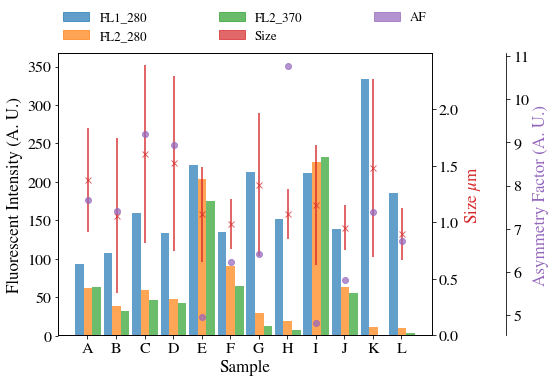

In [10]:
plot_data(table_2008_3, ['1'], "2008_A_3.pdf")

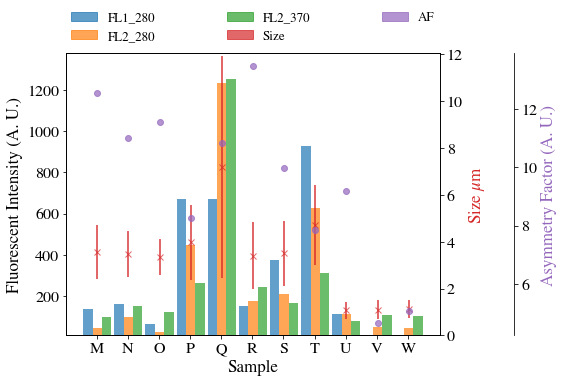

In [11]:
plot_data(table_2008_3, ['2', '3', '4'], "2008_B_3.pdf")

## 2008, Fluorescent Threshold $9\sigma$

In [12]:
params['n_std'] = 9
table_2008_9 = tabulate_data(**params)
table_2008_9.round(2)

,Sample,Label,FL1_280,FL1_280$(\sigma)$,FL2_280,FL2_280$(\sigma)$,FL2_370,FL2_370$(\sigma)$,Size,Size$(\sigma)$,AF,AF$(\sigma)$,N,Sample_Label
3,Bacillus Atrophaeus (unw),1,214.18,80.51,142.53,61.07,163.32,73.97,2.20,0.58,10.25,5.72,34,A
4,"Bacillus Atrophaeus (unw, dil)",1,230.75,281.49,259.25,187.17,242.50,164.00,2.71,2.05,14.37,13.07,4,B
5,Bacillus Atrophaeus (w),1,358.04,218.61,121.56,105.62,110.08,95.72,2.64,1.07,12.35,6.11,217,C
6,"Bacillus Atrophaeus (w, dil)",1,275.97,171.84,128.00,98.62,123.66,103.16,2.59,1.00,14.80,8.05,38,D
7,Bacillus Atrophaeus Vegetative Cells (unw),1,412.27,373.97,389.13,388.60,347.58,382.47,1.32,0.59,4.93,2.45,2051,E
8,"Bacillus Atrophaeus Vegetative Cells (unw, dil)",1,244.42,92.34,166.68,116.33,124.03,103.44,1.20,0.30,7.53,4.60,278,F
9,Bacillus Atrophaeus Vegetative Cells (w),1,346.94,229.06,50.06,71.62,21.34,53.60,1.72,0.91,7.53,3.88,581,G
10,"Bacillus Atrophaeus Vegetative Cells (w, dil)",1,247.48,32.65,26.72,21.35,11.10,16.99,1.34,0.25,13.70,6.88,196,H
13,E coli. (unw),1,397.25,378.98,426.55,455.02,448.57,485.29,1.45,0.72,4.90,2.41,1676,I
14,"E coli. (unw, dil)",1,251.90,106.54,72.82,85.78,66.06,90.45,1.08,0.24,6.61,2.95,413,J


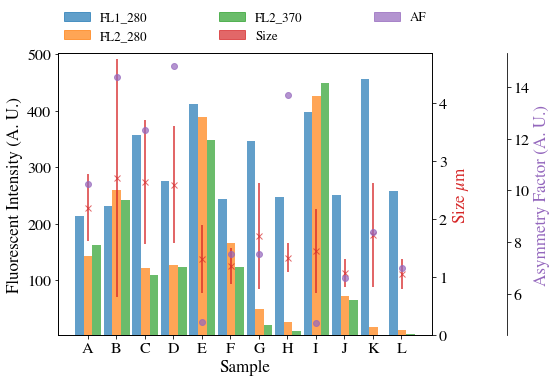

In [13]:
plot_data(table_2008_9, ['1'], '2008_A_9.pdf')

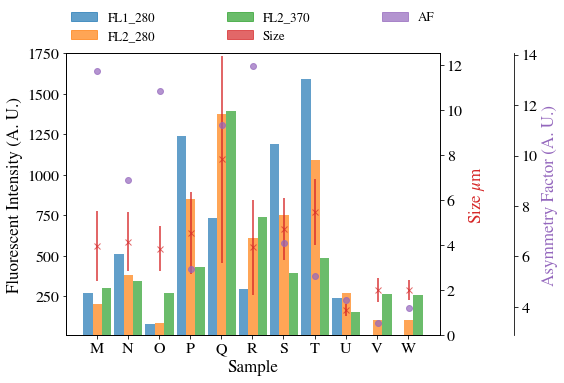

In [14]:
plot_data(table_2008_9, ['2', '3', '4'], '2008_B_9.pdf')

In [15]:
params['n_std'] = None
table_2008 = tabulate_data(**params)
table_2008.round(2)

,Sample,Label,FL1_280,FL1_280$(\sigma)$,FL2_280,FL2_280$(\sigma)$,FL2_370,FL2_370$(\sigma)$,Size,Size$(\sigma)$,AF,AF$(\sigma)$,N,Sample_Label
3,Bacillus Atrophaeus (unw),1,49.36,35.05,26.21,28.80,24.98,32.04,1.02,0.34,6.40,3.01,5778,A
4,"Bacillus Atrophaeus (unw, dil)",1,45.60,30.19,12.16,24.01,9.61,24.05,0.82,0.25,6.05,2.67,1525,B
5,Bacillus Atrophaeus (w),1,74.68,87.90,32.14,37.52,24.79,35.55,1.10,0.55,6.90,3.67,4694,C
6,"Bacillus Atrophaeus (w, dil)",1,59.11,52.90,21.17,29.94,18.49,30.31,0.97,0.44,6.54,3.48,1786,D
7,Bacillus Atrophaeus Vegetative Cells (unw),1,205.90,262.84,188.42,267.51,161.92,258.93,1.03,0.42,5.11,2.28,6142,E
8,"Bacillus Atrophaeus Vegetative Cells (unw, dil)",1,119.62,69.81,79.35,65.03,57.76,55.32,0.93,0.23,6.29,3.50,2192,F
9,Bacillus Atrophaeus Vegetative Cells (w),1,77.37,129.91,11.37,31.91,4.39,24.77,1.09,0.48,6.16,2.93,6002,G
10,"Bacillus Atrophaeus Vegetative Cells (w, dil)",1,127.40,61.80,15.08,21.15,5.98,19.01,1.03,0.23,9.96,5.60,2827,H
13,E coli. (unw),1,183.25,270.40,193.43,314.26,197.96,335.96,1.08,0.51,5.06,2.30,4956,I
14,"E coli. (unw, dil)",1,111.84,90.62,54.28,50.17,49.07,52.10,0.90,0.24,5.98,2.77,2508,J


## 2014, Fluorescent Threshold : $3\sigma$

In [16]:
params = {
    "n_std" : 3,
    "filelist_name" : 'filelist_2014.csv',
    "data_name" :'data_2014.csv'
}
table_2014_3 = tabulate_data(**params)
table_2014_3.round(2)

,Sample,Label,FL1_280,FL1_280$(\sigma)$,FL2_280,FL2_280$(\sigma)$,FL2_370,FL2_370$(\sigma)$,Size,Size$(\sigma)$,AF,AF$(\sigma)$,N,Sample_Label
6,Bacillus Atrophaeus (unwashed),1,81.88,100.79,41.24,39.40,19.88,51.25,1.00,0.40,7.94,3.98,2685,A
10,Bacillus Atrophaeus (washed),1,8.65,58.29,157.02,184.04,259.46,313.33,1.02,0.47,5.48,2.23,2248,B
11,E. coli (unwashed),1,85.95,170.90,151.79,189.76,269.72,363.90,1.20,0.62,6.26,2.88,1640,C
5,Puffball I,2,287.23,524.10,221.23,299.07,170.20,184.41,3.39,1.76,12.17,9.80,506,D
13,Puffball II,2,-19.57,18.11,64.37,50.62,118.37,109.30,2.50,0.86,17.57,8.86,35,E
14,Puffball III,2,19.44,170.78,64.19,70.65,100.19,62.26,2.45,1.20,20.61,12.71,16,F
15,Aspen Pollen,3,131.28,388.43,301.04,507.83,447.58,635.70,3.72,2.52,17.19,7.56,74,G
4,Paper mulberry pollen,3,99.59,78.03,1900.96,332.07,1917.24,284.18,11.27,1.75,11.78,5.51,543,H
16,Poplar Pollen,3,163.20,490.95,338.19,527.97,496.22,646.43,3.63,2.40,17.00,9.17,104,I
9,Ryegrass pollen,3,110.67,348.43,278.67,264.99,569.33,441.62,3.25,2.17,18.42,8.86,21,J


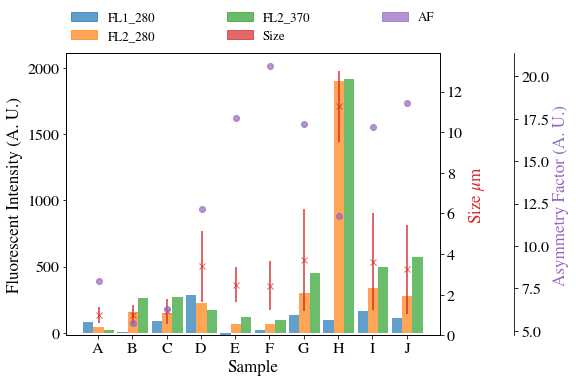

In [17]:
plot_data(table_2014_3, ['1', '2', '3'], "2014_3.pdf")

## 2014, Fluorescent Threshold : $9\sigma$

In [18]:
params['n_std'] = 9
table_2014_9 = tabulate_data(**params)
table_2014_9.round(2)

,Sample,Label,FL1_280,FL1_280$(\sigma)$,FL2_280,FL2_280$(\sigma)$,FL2_370,FL2_370$(\sigma)$,Size,Size$(\sigma)$,AF,AF$(\sigma)$,N,Sample_Label
6,Bacillus Atrophaeus (unwashed),1,189.80,141.11,59.31,63.36,44.20,87.69,1.35,0.53,9.80,4.69,735.0,A
10,Bacillus Atrophaeus (washed),1,58.66,82.00,335.89,253.62,597.40,398.29,1.54,0.55,4.81,2.19,679.0,B
11,E. coli (unwashed),1,193.14,225.54,274.77,247.59,530.17,455.37,1.65,0.73,6.25,3.15,669.0,C
5,Puffball I,2,597.38,607.02,386.98,355.82,254.61,229.09,4.25,1.77,8.66,8.19,249.0,D
13,Puffball II,2,-20.67,21.36,176.67,93.09,417.33,179.49,2.40,0.80,19.71,11.02,3.0,E
14,Puffball III,2,654.00,NaN,298.00,NaN,284.00,NaN,2.01,NaN,25.56,NaN,1.0,F
15,Aspen Pollen,3,338.03,538.61,643.55,646.37,951.97,727.91,5.01,3.27,18.70,8.79,31.0,G
4,Paper mulberry pollen,3,100.97,77.29,1921.76,268.79,1937.67,209.27,11.38,1.40,11.77,5.50,537.0,H
16,Poplar Pollen,3,355.86,657.72,644.46,632.91,938.78,701.50,4.37,2.94,16.48,9.95,50.0,I
9,Ryegrass pollen,3,168.07,401.30,361.53,272.75,753.33,389.08,3.63,2.46,17.81,9.83,15.0,J


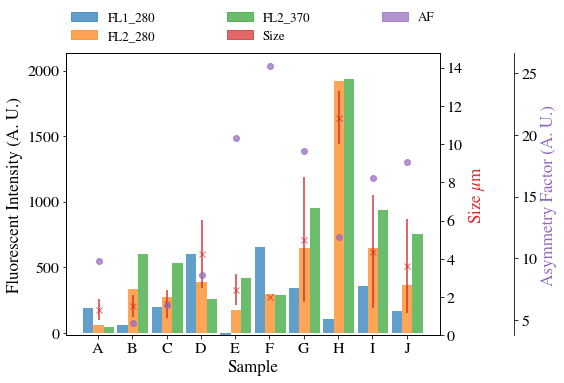

In [ ]:
plot_data(table_2014_9, ['1', '2', '3'], "2014_9.pdf")

# Scatter plots of samples

In [ ]:
# make a scatter directory

def plot_scatter(sub_dir):
    colors = ['#1f77b4','#ff7f0e','#2ca02c']
    
    scatter_directory = os.path.join(os.curdir, "scatter")
    scatter_subdirectory = os.path.join(scatter_directory, sub_dir)
    if not os.path.exists(scatter_directory):
        os.mkdir(scatter_directory)
    if not os.path.exists(scatter_subdirectory):
        os.mkdir(scatter_subdirectory)

    # load in the data
    df = load_data('data_{}.csv'.format(sub_dir))
    filelist = pd.read_csv('filelist_{}.csv'.format(sub_dir))

    counts = pd.DataFrame({
        'filename' :filelist['Short Name'],
        'counts' : df.groupby('File_Label').count()['Size']
        })
    
    print(counts)


    # get max size


    # get threshold 3 and 9
    thr_3 = get_threshold(df, n_std = 3)
    thr_9 = get_threshold(df, n_std = 9)


    for file_idx, file_line in filelist.iterrows():
        sample = df[df['File_Label'] == file_idx]

        if file_line['Label'] == 'F':
            continue

        print(file_line['Short Name'], int(sample.count()['Size']))
        size = sample['Size']

        # create subplots
        fig, ax = plt.subplots(1, 3, sharey=True)
        fig.set_tight_layout(False)
        for i, column in enumerate(['FL1_280','FL2_280', 'FL2_370']):
            FL = sample[column]
            ax[i].scatter(size, FL, color = colors[i], alpha = 0.5)
            ax[i].axhline(thr_3[i], color = colors[i])
            ax[i].axhline(thr_9[i], color = colors[i], linestyle = '--')

            # set the x ticks

            m_size = np.max(sample['Size'])+1
            if m_size < 3:
                ax[i].set_xticks(np.arange(0, m_size, 0.5))
            elif m_size < 6:
                ax[i].set_xticks(np.arange(0, m_size, 1))
            else: 
                 ax[i].set_xticks(np.arange(0, m_size, 2))


            fig.text(0.5, 0.04, 'Size ($\mu$m)', ha='center')
            fig.text(0.04, 0.5, 'Fluorescence (A. U.)', va='center', rotation='vertical')
            ax[i].set_title(column)
        filename = os.path.join(scatter_subdirectory, file_line['Short Name'] + '.png')
        fig.suptitle(file_line['Short Name'])
        plt.savefig(filename,dpi = 600)
        plt.show()


                                           filename  counts
0                                               NaN     255
1                                               NaN     596
2                                     Bermuda grass    5220
3                         Bacillus Atrophaeus (unw)    5778
4                    Bacillus Atrophaeus (unw, dil)    1525
5                           Bacillus Atrophaeus (w)    4694
6                      Bacillus Atrophaeus (w, dil)    1786
7        Bacillus Atrophaeus Vegetative Cells (unw)    6142
8   Bacillus Atrophaeus Vegetative Cells (unw, dil)    2192
9          Bacillus Atrophaeus Vegetative Cells (w)    6002
10    Bacillus Atrophaeus Vegetative Cells (w, dil)    2827
11                                     Birch pollen     164
12                                     Diesel smoke    7900
13                                    E coli. (unw)    4956
14                               E coli. (unw, dil)    2508
15                                      

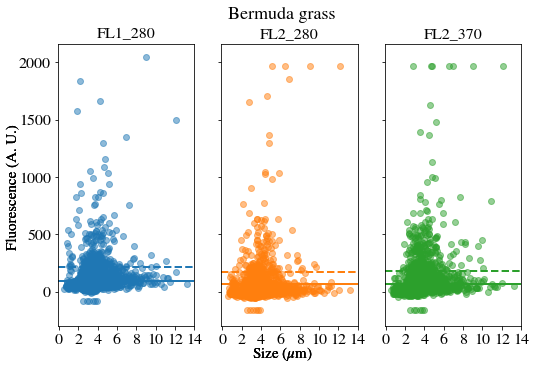

Bacillus Atrophaeus (unw) 5778


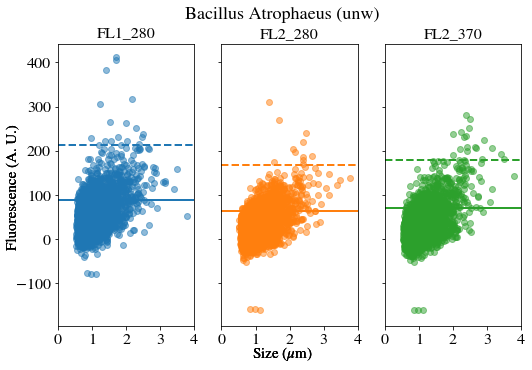

Bacillus Atrophaeus (unw, dil) 1525


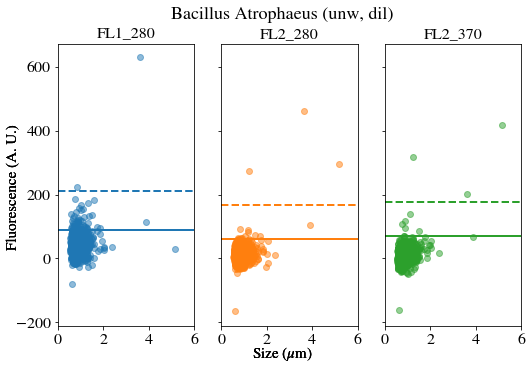

Bacillus Atrophaeus (w) 4694


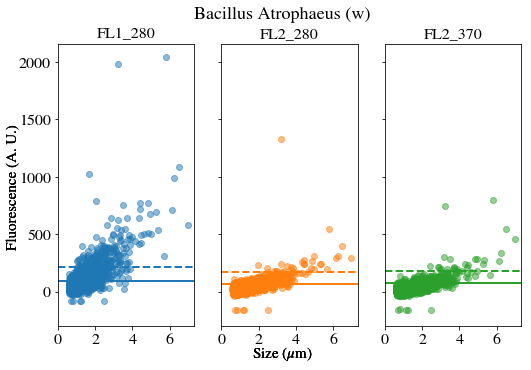

Bacillus Atrophaeus (w, dil) 1786


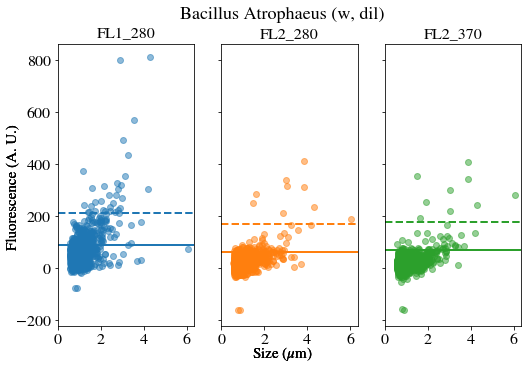

Bacillus Atrophaeus Vegetative Cells (unw) 6142


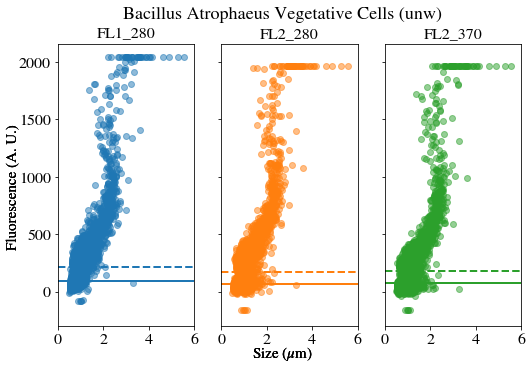

Bacillus Atrophaeus Vegetative Cells (unw, dil) 2192


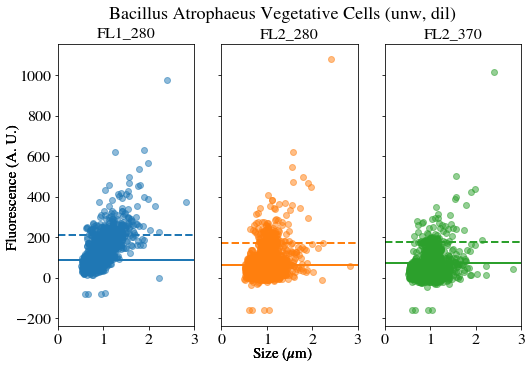

Bacillus Atrophaeus Vegetative Cells (w) 6002


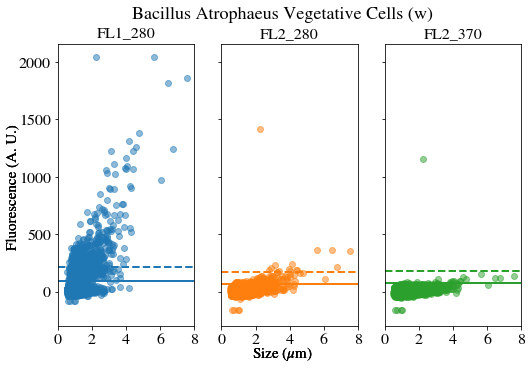

Bacillus Atrophaeus Vegetative Cells (w, dil) 2827


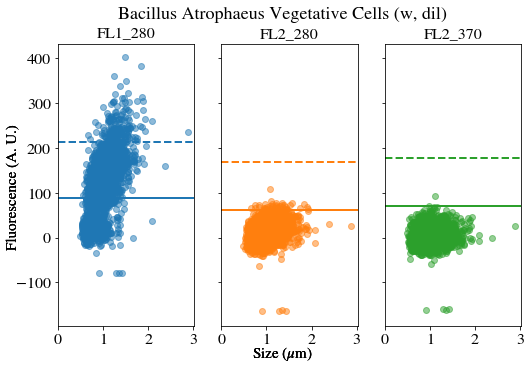

Birch pollen 164


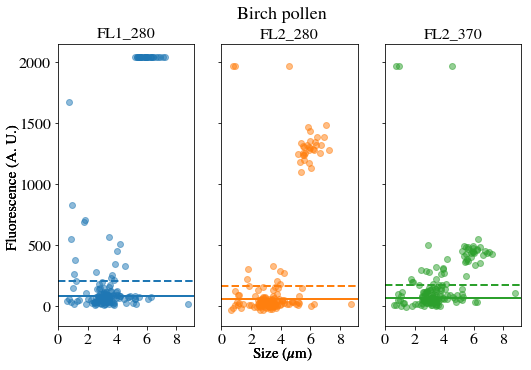

Diesel smoke 7900


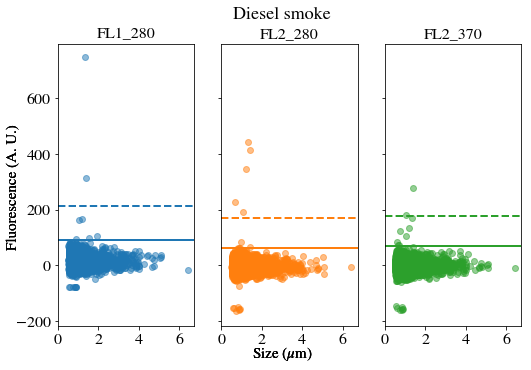

E coli. (unw) 4956


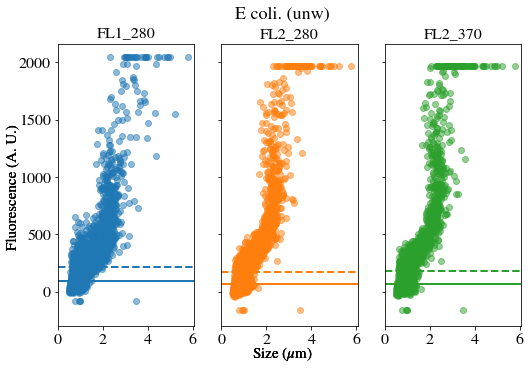

E coli. (unw, dil) 2508


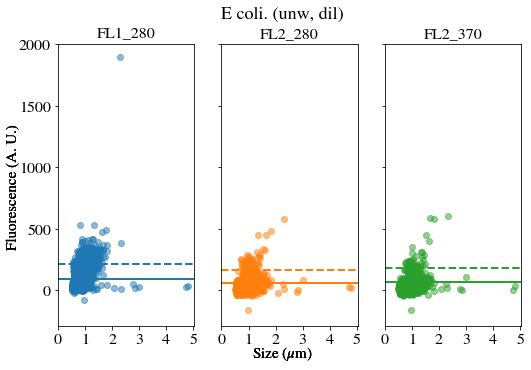

E coli. (w) 5669


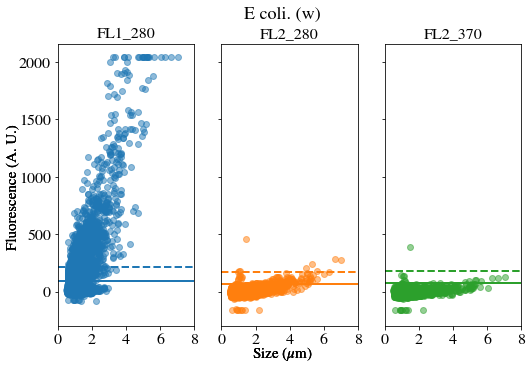

E coli. (w, dil) 2104


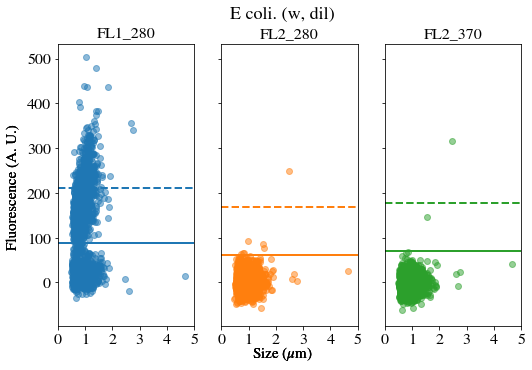

Grass smoke I 9212


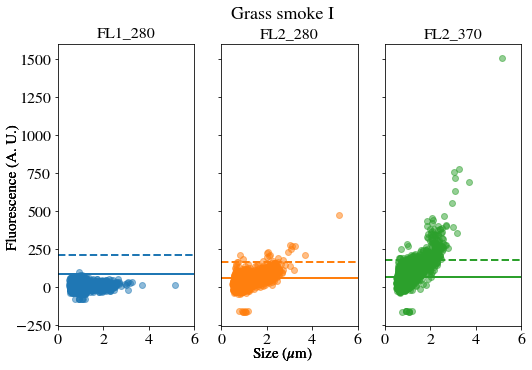

Grass smoke II 5245


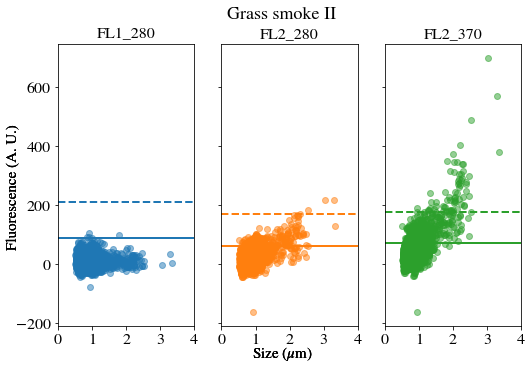

Johnson Grass I 2157


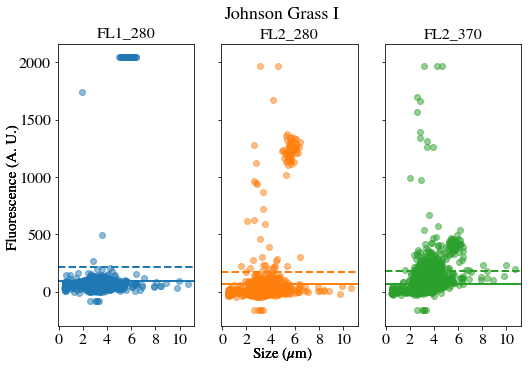

Johnson Grass II 5091


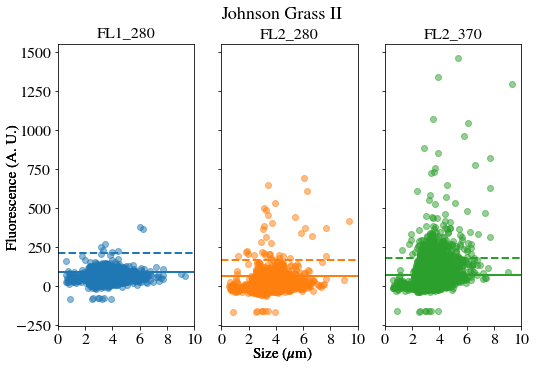

Paper mulberry I 295


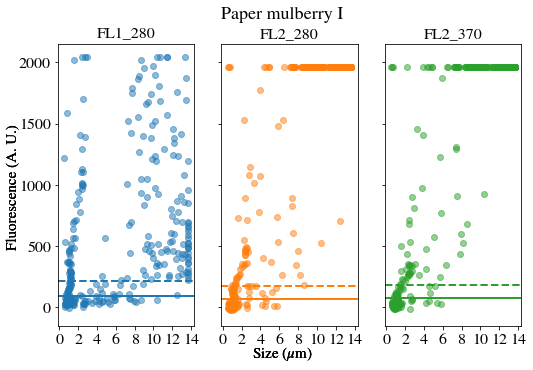

Paper mulberry II 735


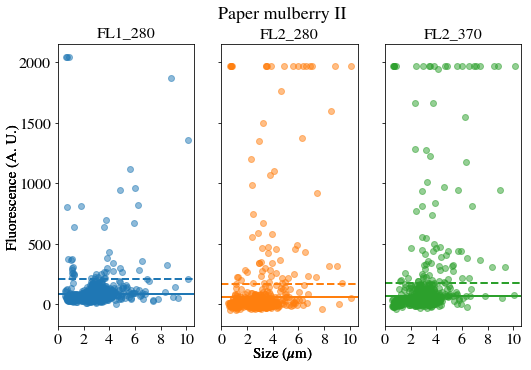

Ragweed I 241


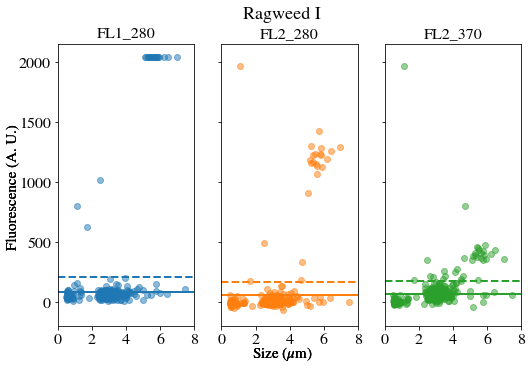

Ragweed II 328


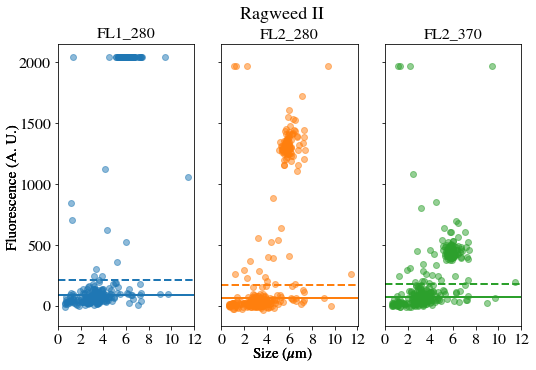

In [ ]:
plot_scatter('2008')

                          filename  counts
0                              NaN     NaN
1                              NaN   259.0
2                              NaN   255.0
3                              NaN   256.0
4            Paper mulberry pollen   565.0
5                       Puffball I  1627.0
6   Bacillus Atrophaeus (unwashed)  3321.0
7                    Fullers Earth  3064.0
8        Phosphate Buffered Saline  3226.0
9                  Ryegrass pollen    47.0
10    Bacillus Atrophaeus (washed)  2896.0
11              E. coli (unwashed)  2534.0
12                            NaCl  2197.0
13                     Puffball II  1739.0
14                    Puffball III   553.0
15                    Aspen Pollen   398.0
16                   Poplar Pollen   375.0
Paper mulberry pollen 565


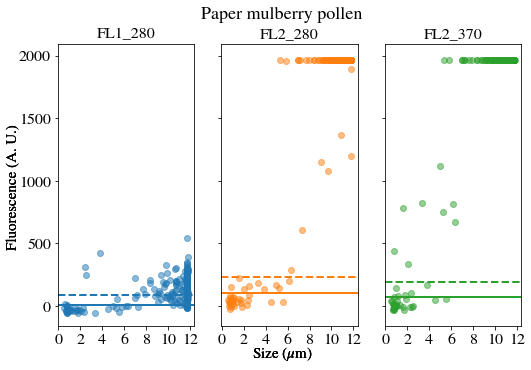

Puffball I 1627


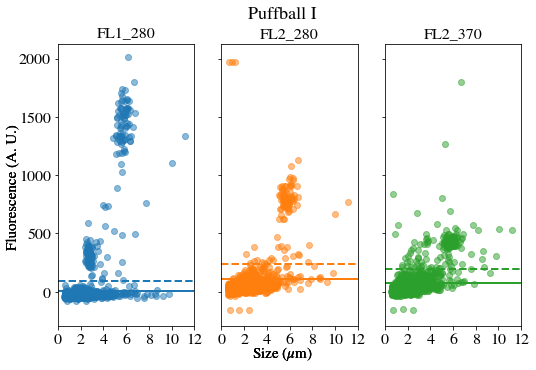

Bacillus Atrophaeus (unwashed) 3321


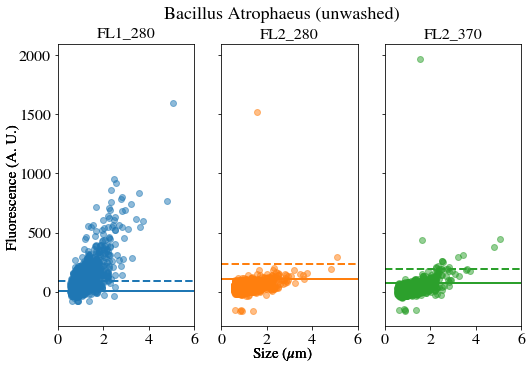

Fullers Earth 3064


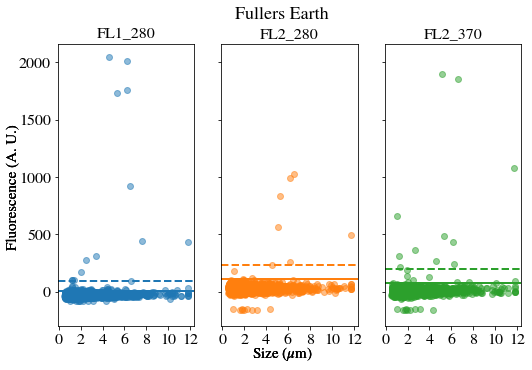

Phosphate Buffered Saline 3226


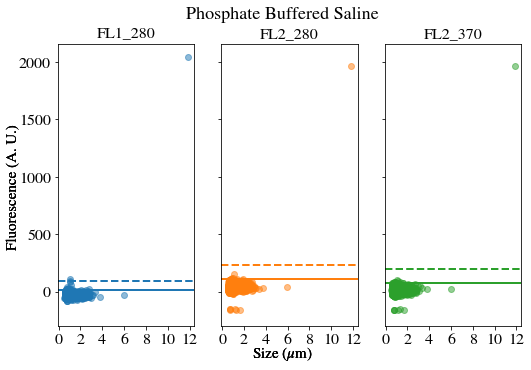

Ryegrass pollen 47


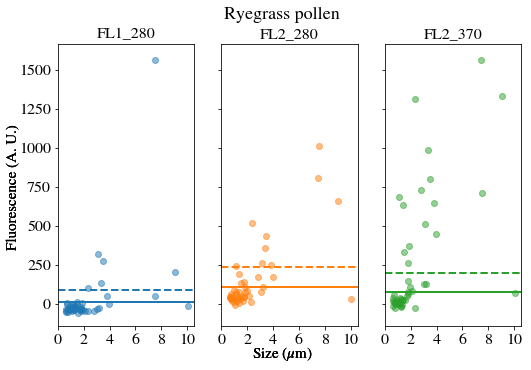

Bacillus Atrophaeus (washed) 2896


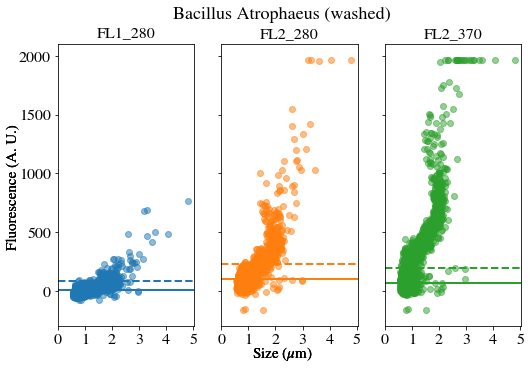

E. coli (unwashed) 2534


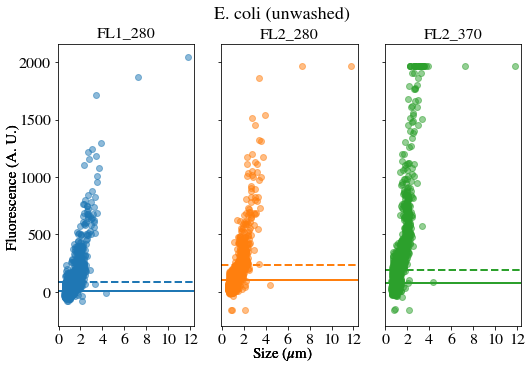

NaCl 2197


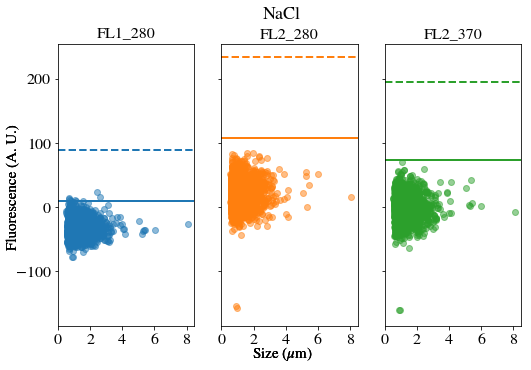

Puffball II 1739


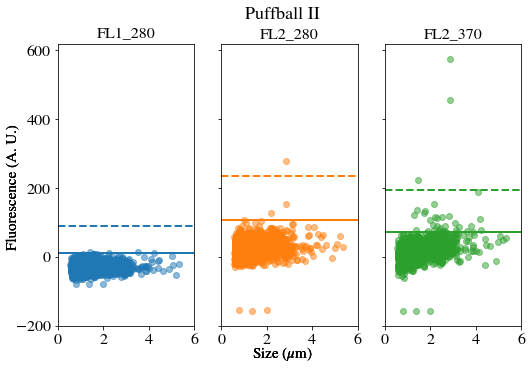

Puffball III 553


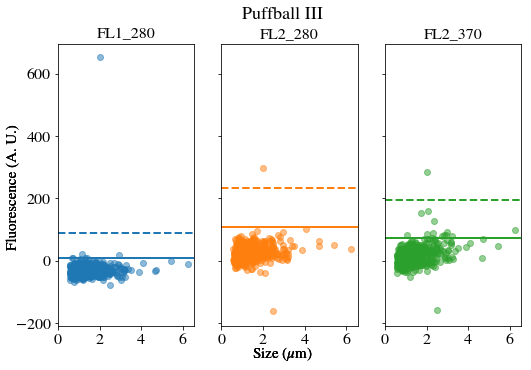

Aspen Pollen 398


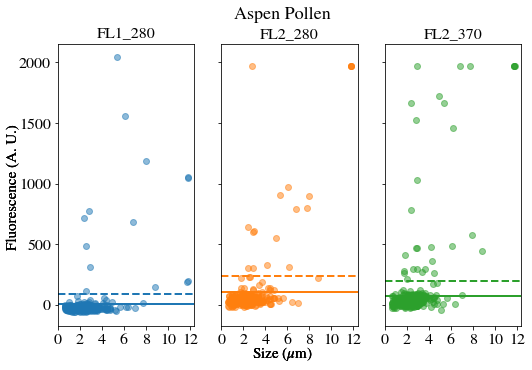

Poplar Pollen 375


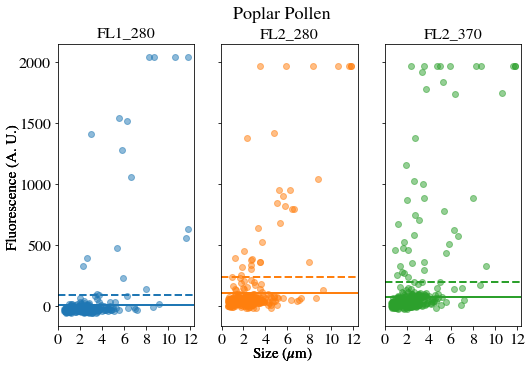

In [ ]:
plot_scatter('2014')

# HAC
## PSL
This dataset is the same as the one used in Crawford, 2015 and we begin by reproducing the results from there. 

Crawford, I., et al. "Evaluation of hierarchical agglomerative cluster analysis methods for discrimination of primary biological aerosol." Atmospheric Measurement Techniques 8.11 (2015): 4979-4991.

Start by loading in the data frame.

In [ ]:
df = load_data('data_PSL.csv')
filelist = pd.read_csv("filelist_PSL.csv")

Once we have read in the data we need to create some additional functions to preprocess the data. The first will split the data frame into the particle data and the forced trigger data. We can check that the number of particles for each class by comparing with Table 1 from Crawford, 2015 below.

![Table 1](table_1.png)

In [ ]:
def split_frame(df):
    
    '''
    Function that splits the data frame into 
    aquisition data and forced trigger data
    '''
    data = df.loc[df['Label'] != 'F']
    FT = df.loc[df['Label'] == 'F']
    return data, FT

In [ ]:
data, FT = split_frame(df)
data.groupby('Label').size()

Label
1    5055
2    8796
3    8942
4    7976
5    8927
dtype: int64

In [ ]:
filelist

,Filename,Label,Short Name
0,1_green_0000.csv,1,$1\mu$m Green I
1,1_green_0001.csv,1,$1\mu$m Green I
2,2.1_blue_0000.csv,2,$2.1\mu$m Blue
3,2.2_red_0000.csv,3,$2.2\mu$m Red
4,3.1_green_0000.csv,4,$3.1\mu$m Green
5,4.17_0000_0001.csv,5,$4.17\mu$m I
6,4.17_0000_0002.csv,5,$4.17\mu$m II
7,4.17_0000_0003.csv,5,$4.17\mu$m III
8,FT2_0000.csv,F,NaN
9,FT_0000.csv,F,NaN


Next, we write a function that will remove all but the fluorescence, size and shape columns which will be clustered. The function is tested on the first 5 rows.

In [ ]:
def reduce_columns(df):
    required_columns = ['FL1_280', 'FL2_280', 'FL2_370', 'Size', 'AF']
    return df[required_columns], df['Label'], df['File_Label']
reduce_columns(df[:5])

(   FL1_280  FL2_280  FL2_370   Size     AF
 0      308     2112     2047  2.007  2.018
 1      336     2112     2047  1.534  2.050
 2      354     2112     2047  1.722  1.963
 3      317     2112     2047  2.117  2.508
 4      328     2112     2047  1.857  1.513, 0    1
 1    1
 2    1
 3    1
 4    1
 Name: Label, dtype: object, 0    0
 1    0
 2    0
 3    0
 4    0
 Name: File_Label, dtype: int64)

We then write a function that will threshold a particular parameter. This can then be used to apply the size thresholds, and remove any erroneous particles which have an assymmetry factor of less than 0.

In [ ]:
def df_threshold(df, parameter = 'Size', threshold = 0.8):
    return df.loc[df[parameter] > threshold]
df_threshold(df[:5], 'Size', 0.8)

,Time,FL2 SctInt,Scat_EL1,Scat_EL2,Scat_EL3,Scat_EL4,FL2 SctPk,FL1_280,FL2_280,Pwr_280,...,Size,AF,TotalT2,MeasT2,FT,TPCT1,TotalT1,Label,File_Label,Pw
0,149,216,45,38,54,55,49,308,2112,2047,...,2.007,2.018,24.0,20.8,2,0,22.33,1,0,NaN
1,157,196,39,36,49,47,35,336,2112,2047,...,1.534,2.050,24.0,20.8,2,0,22.33,1,0,NaN
2,197,186,45,38,55,56,40,354,2112,2047,...,1.722,1.963,24.0,20.8,2,0,22.33,1,0,NaN
3,240,186,44,39,53,57,53,317,2112,2047,...,2.117,2.508,24.0,20.8,2,0,22.33,1,0,NaN
4,269,191,39,36,50,52,44,328,2112,2047,...,1.857,1.513,24.0,20.8,2,0,22.33,1,0,NaN


In addition we write a function that can apply a fluorescent threshold to the data. In Crawford, 2015 the threshold was applied by subtracting the threshold and then removing any particles with negative measurements in each fluorescence channel and then clipping the remaining measurements at zero. In the current manuscript with simply apply the threshold by removing particles which fail to exceed it.

In the interests of being able to reproduce the results from Crawford, 2015 we include a function which applies the threshold in this fashion.

Note that a warning when applying the clip may appear. We were unable to remove this warning, but we checked the output of the function, and the function is working as intended. 

The tests include checking that the number of particles decreases as the threshold is applied, checking that the average fluorescence gets greater as the threshold is applied and checking that if the measurements are clipped that the lower fluorescence measurement is indeed zero.

In [ ]:
def FL_threshold(df, n_std, clip = False):
    if clip:
        return FL_threshold_clip(df, n_std)
    thr = get_threshold(df, n_std)
    return apply_threshold(df, thr)

def FL_threshold_clip(df, n_std):
    # get the threshold
    thr = get_threshold(df, n_std)
    
    # subtract threshold from particle data
    FL_cols = ['FL1_280', 'FL2_280', 'FL2_370']
    df[FL_cols] = df[FL_cols] - np.array(thr, 'float')
    df = apply_threshold(df, [0, 0, 0])
    
    # clip the data at zero
    clipped = df.loc[:, FL_cols].clip_lower(0, axis='columns')
    df.loc[:, FL_cols] = clipped
    
    return df
    
# test to see that once a threshold applies there are  less particles
# and that the average fluorescence decreases
df = load_data('data_PSL.csv')
print("Threshold : ", get_threshold(df, 3))

print("Change in N (before-after) :", df['FL1_280'].count() - FL_threshold(df, 3)['FL1_280'].count())
print("Change in average FL (after-before) :", FL_threshold(df, 3)['FL1_280'].mean() - df['FL1_280'].mean())

# repeat tests and then check the values of the fluorescence are at least zero (i.e. the clip has worked)
# test that the applying the clipped threshold produces fluorescence values of at least zero
df = load_data('data_PSL.csv')
thr_df  = FL_threshold_clip(df, 3)
print("Change in N (before - after) : ", df['FL1_280'].count() - thr_df['FL1_280'].count())
print("Change in average FL (after-before) : ",thr_df['FL1_280'].mean() - df['FL1_280'].mean())
print("Minimum FL1_280 value", thr_df['FL1_280'].min())

Threshold :  [25.705707644755794, 9.059374795283697, -25.655797224182592]
Change in N (before-after) : 7647
Change in average FL (after-before) : 130.49868006920394
Change in N (before - after) :  7647
Change in average FL (after-before) :  130.5482091088868
Minimum FL1_280 value 0.0


Also, we write a function to take logs of the size and AF. To test this we check that we can take the exponential to reproduce the original data.

In [ ]:
def take_logs(df):
    temp = df.copy()
    temp['AF'] = np.log(temp['AF'])
    temp['Size'] = np.log(temp['Size'])
    return temp

# test
df = df_threshold(df, "Size", 0)
df = df_threshold(df, "AF", 0)
np.max(np.exp(take_logs(df)['Size'])-df['Size'])

1.7763568394002505e-15

We then write a function that applies the standardisation, either z-score or range.

In [ ]:
def standardise(data, method = 'zscore'):
    if method == 'zscore':
        return (data - data.mean(axis = 0))/(data.std(axis = 0))
    elif method == 'range':
        return (data - data.min(axis=0))/(data.max(axis = 0)-data.min(axis=0))

# test
print(standardise(reduce_columns(df)[0], 'zscore').mean())
print(standardise(reduce_columns(df)[0], 'zscore').std())
print(standardise(reduce_columns(df)[0], 'range').min())
print(standardise(reduce_columns(df)[0], 'range').max())

FL1_280   -3.187271e-13
FL2_280   -7.900085e-13
FL2_370    6.910284e-13
Size      -2.757921e-14
AF         1.788996e-14
dtype: float64
FL1_280    1.0
FL2_280    1.0
FL2_370    1.0
Size       1.0
AF         1.0
dtype: float64
FL1_280    0.0
FL2_280    0.0
FL2_370    0.0
Size       0.0
AF         0.0
dtype: float64
FL1_280    1.0
FL2_280    1.0
FL2_370    1.0
Size       1.0
AF         1.0
dtype: float64


We then put all the preparation functions together into a single function

In [ ]:
def prepare(df, size_thr = 0.8, n_std = 3, logs=True, standardisation='zscore', clip = False):
    
    if n_std != None:
        temp = FL_threshold(df, n_std, clip)
    else:
        print('Not applying threshold')
        temp = df.copy()
        
    temp, FT = split_frame(temp)
    
    # remove negs for size and AF
    temp = df_threshold(temp, "Size", 0)
    temp = df_threshold(temp, "AF", 0)
    temp = df_threshold(temp, "Size", size_thr)
    temp, labels, file_labels = reduce_columns(temp)
    
    if logs == True:
        temp = take_logs(temp)
        
    if standardisation != None:
        temp = standardise(temp, standardisation)

    return temp, labels, file_labels

Then we test that we can reproduce the results from Crawford, 2015 in Table 2
![Table 2](table_2.png)

In [ ]:
from fastcluster import linkage_vector
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import confusion_matrix

def analyse_PSL(reproduce = False):
    df = load_data("data_PSL.csv")
    
    # in crawford 2015, the data was clipped at zero and only one of the forced trigger files was used.
    if reproduce:
        df = df[df['File_Label'] !=8]
        data, labels, _ = prepare(df, clip=True)
        
    else:
        data, labels, _ = prepare(df)
    
    # analyse
    l = linkage_vector(data, 'ward')
    e = fcluster(l, 5, 'maxclust')
    M = confusion_matrix(e, np.array(labels, 'int'))
    print(M)
    print(np.sum(np.max(M, 1)) / np.sum(M))

In [ ]:
analyse_PSL()

[[   0    5   73 7607    0]
 [  20 8492   20   10    0]
 [   0   21   39   54 6253]
 [3754   20   26   12  142]
 [  86   12 8299   21   65]]
0.982130113328195


In [ ]:
analyse_PSL(reproduce=True)

[[   0    5   73 7608    0]
 [  20 8492   20    9    0]
 [   0   23   46   60 6279]
 [3754   24   30   14  153]
 [  86   13 8301   24   54]]
0.9813611491108071


The two main differences between the current manuscript and Crawford, 2015 are
* We do not clip the measurements
* We use an extra forced trigger file which results in a slightly higher fluorescence threshold

However, from the output we can see this does not have any significant impact upon the number of particles correctly classifier. 

From this point forth in the notebook, we do not clip the measurements as we did in Crawford, 2015.

## Test the different combinations
Finally we test the different options in terms of
* What size threshold is used (0 or 0.8)
* What fluorescence threshold is used (None, 3 or 9 $\sigma$)
* Whether we take logs (Yes or No)
* What standardisation we use (zscore or range)
* What linkage we use (single, ward, centroid or median)

In [ ]:
def test_all(data_sub_dir):
    
    # previously we had an error where we set the fluorescence threshold 
    # to average + 0 std instead of not using a threshold at all
    # To reproduce this error comment out set the following instead
    #fl_list = [0, 3, 9]  # (INCORRECT)
    # the incorrect linkages are stored in a different folder
    
    fl_list = [None, 3, 9]
    
    # set up directories
    
    HAC_dir = os.path.join(os.curdir, "HAC")
    if not os.path.exists(HAC_dir):
        os.mkdir(HAC_dir)
        
    linkage_dir = os.path.join(HAC_dir, "linkages")
    if not os.path.exists(linkage_dir):
        os.mkdir(linkage_dir)
        
    sub_dir = os.path.join(linkage_dir, data_sub_dir)
    if not os.path.exists(sub_dir):
        os.mkdir(sub_dir)
    else:
        return
        
    # run on different combinations
    t = 0
    for size_thr in [0, 0.8]:
        for fl_thr in fl_list:
            for logs in [True, False]:
                for standardisation in ['zscore', 'range']:
                    df = load_data('data_{}.csv'.format(data_sub_dir))
                    data, labels, _ = prepare(df, size_thr, fl_thr, logs, standardisation, clip = False)

                    for linkage in ['single', 'ward', 'centroid', 'median']:
                        filename = os.path.join(sub_dir, "linkage_{}".format(t))
                        try:
                            l = linkage_vector(data, linkage)
                            np.savetxt(filename, l, delimiter=',')
                        except Exception as e:
                            print(e)
                            return
                        
                        t+=1

In [ ]:
#for directory in ['2008', '2014', 'PSL']:
    #test_all(directory)

In [ ]:
from sklearn.metrics import calinski_harabaz_score, adjusted_rand_score
from proportion import proportion
from cluster_utils import extract

def get_indices(data_sub_dir):
    
        
    # previously we had an error where we set the fluorescence threshold 
    # to average + 0 std instead of not using a threshold at all
    # To reproduce this error comment out set the following instead
    #fl_list = [0, 3, 9]  # (INCORRECT)
    # the incorrect linkages are stored in a different folder
    fl_list = [None, 3, 9]
    
    # set up directories
    HAC_dir = os.path.join(os.curdir, "HAC")
    linkage_dir = os.path.join(HAC_dir, "linkages")
    sub_dir = os.path.join(linkage_dir, data_sub_dir)
    df = load_data("data_{}.csv".format(data_sub_dir))
    t = 0
    m = 0
    AR = np.zeros((96, 10))
    P = np.zeros((96, 10))
    CH = np.zeros((96, 10))
    for size_thr in [0, 0.8]:
        for fl_thr in fl_list:
            for logs in [True, False]:
                for standardisation in ['zscore', 'range']:
                    data, labels, _ = prepare(df, size_thr, fl_thr, logs, standardisation)
                    for linkage in ['single', 'ward', 'centroid', 'median']:
                        filename = os.path.join(sub_dir, "linkage_{}".format(t))
                        l = np.genfromtxt(filename, delimiter=',')
                        e = extract(l, 1, 10)
                        for i in range(10):
                            AR[t, i] = adjusted_rand_score(labels, e[i])
                            P[t, i] = proportion(labels, e[i])
                            try:
                                CH[t, i] = calinski_harabaz_score(data, e[i])
                            except Exception:
                                CH[t, i] = 0
                        t+=1
    return AR, CH, P

In [ ]:
for data_sub_dir in ['2008', '2014', 'PSL']:
    
    # filenames
    filename_AR = "AR_{}.csv".format(data_sub_dir)
    filename_CH = "CH_{}.csv".format(data_sub_dir)
    filename_P = "P_{}.csv".format(data_sub_dir)
    
    c1 = os.path.exists(filename_AR)
    c2 = os.path.exists(filename_CH)
    c3 = os.path.exists(filename_P)
    if not c1 & c2 & c3:
        print('Creating files : {}'.format(data_sub_dir))
        AR, CH, P = get_indices(data_sub_dir)
        np.savetxt(filename_AR, AR, delimiter=',')
        np.savetxt(filename_CH, CH, delimiter=',')
        np.savetxt(filename_P, P, delimiter=',')
        
    else:
        print('Already exists loading {}'.format(data_sub_dir))
        AR = np.genfromtxt(filename_AR, delimiter=',')
        CH = np.genfromtxt(filename_CH, delimiter=',')
        P = np.genfromtxt(filename_P, delimiter=',')

Already exists loading 2008
Already exists loading 2014
Already exists loading PSL


# Checksums for AR scores

In [ ]:
for data_set in ['2008', '2014', 'PSL']:
    AR = np.genfromtxt('AR_{}.csv'.format(data_set), delimiter=',')
    print(np.sum(np.max(AR, 1)))

14.890337619637744
29.459861570436335
52.17913488612652


# Plot adjusted rand scores

Get indices of the rows corresponding to the following 
* z-score, size > 0.8, FL > 3, ward, take logs
* z-score, size > 0.8, FL > 9, ward, take logs

In [ ]:
t = 0
combinations = []
fl_list = [None, 3, 9]
for size_thr in [0, 0.8]:
    for fl_thr in fl_list:
        for logs in [True, False]:
            for standardisation in ['zscore', 'range']:
                for linkage in ['single', 'ward', 'centroid', 'median']:
                    combinations.append([size_thr, fl_thr,
                                       logs, standardisation, 
                                       linkage])
                    # requirements
                    r1 = size_thr == 0.8
                    r2 = logs == True
                    r3 = standardisation == 'zscore'
                    r4 = linkage == 'ward'
                    if r1 & r2 & r3 & r4:
                        if fl_thr == 3:
                            print("3: ", t)
                        if fl_thr == 9:
                            print("9: ", t)
                    t+=1
len(combinations)

3:  65
9:  81


96

In [ ]:
combinations[65]

[0.8, 3, True, 'zscore', 'ward']

In [ ]:
combinations[81]

[0.8, 9, True, 'zscore', 'ward']

In [ ]:
heights = [[], [], []] # each corresponds to blue, orange and green
bases = [[], [], []] 
for data_set in ['PSL', '2008', '2014']:
    
    AR = np.genfromtxt('AR_{}.csv'.format(data_set), delimiter=',')
    CH = np.genfromtxt('CH_{}.csv'.format(data_set), delimiter=',')
    
    
    # for each of the 96 combinations
    AR_where_CH_max = []
    N_where_CH_max = []
    for cur_AR, cur_CH in zip(AR, CH):
        
        # look for the location of the highest CH for that row
        col = np.argmax(cur_CH)
        AR_where_CH_max.append(cur_AR[col])
        
        
        
        
    best_CH_idx = np.argmax(AR_where_CH_max)
    print("produced best inc. CH\t", combinations[best_CH_idx])
    
    # find best_AR index
    best_idx = np.where(AR == np.max(AR))[0][0]
    
    idx_list = [65, 81, best_CH_idx]
    print("produced best hierarchy\t", combinations[best_idx])
    
    for i, idx in enumerate(idx_list):
        
        # maximum adjusted rand score
        heights[i].append(np.max(AR[idx]))
        
        # adjusted rand score where CH is highest
        heights[i].append(AR[idx, np.argmax(CH[idx])])
        
        # number of clusters where adjusted rand score is highest
        bases[i].append(np.argmax(AR[idx])+1)
        
        # number of clusters where CH is highest
        bases[i].append(np.argmax(CH[idx])+1)    

produced best inc. CH	 [0.8, 9, True, 'zscore', 'ward']
produced best hierarchy	 [0.8, 9, True, 'zscore', 'ward']
produced best inc. CH	 [0.8, 3, True, 'range', 'ward']
produced best hierarchy	 [0.8, 3, True, 'range', 'ward']
produced best inc. CH	 [0.8, 9, False, 'zscore', 'centroid']
produced best hierarchy	 [0, 9, False, 'zscore', 'centroid']


In [ ]:
heights

[[0.9595760466846208,
  0.9595760466846208,
  0.4829702447517002,
  0.482612173304391,
  0.46239172843334053,
  0.45366140092005536],
 [0.9684896093617824,
  0.9684896093617824,
  0.276569659789828,
  0.12138940820709052,
  0.6192559495122347,
  0.6192559495122347],
 [0.9684896093617824,
  0.9684896093617824,
  0.5672064012660498,
  0.5672064012660498,
  0.7339438755153413,
  0.733620296855514]]

In [ ]:
bases

[[5, 5, 5, 4, 3, 2], [5, 5, 5, 2, 3, 3], [5, 5, 3, 3, 7, 6]]

# Create plot

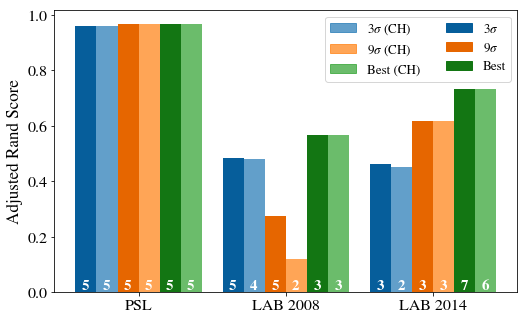

In [ ]:
plt.style.use("single.mplstyle")

colors = ['#1f77b4','#ff7f0e','#2ca02c']
# https://www.hexcolortool.com/# was used to darken colors (10%)
dark_colors = ['#065E9B', '#E66600', '#137613']
fig, ax = plt.subplots()
fig.set_tight_layout(False)

for i, height_list in enumerate(heights):
    best_AR = height_list[::2]
    best_AR_CH = height_list[1::2]
    ax.bar(np.arange(0, 9, 3.5)+i, best_AR, width = 0.5, color = dark_colors[i])
    ax.bar(np.arange(0, 9, 3.5)+0.5+i, best_AR_CH, width = 0.5, color = colors[i], alpha = 0.7)

# add base numbers
for i, base_list in enumerate(bases):
    best_N = base_list[::2]
    best_CH = base_list[1::2]
    for j in range(3):
        ax.text(j*3.5+i-0.1, 0.01, best_N[j], color = 'white', fontsize=15, fontweight='bold')
        ax.text(j*3.5+i+0.5-0.1, 0.01, best_CH[j], color = 'white', fontsize=15, fontweight='bold')
    
# set the xticks
ax.set_xticks(np.arange(1.25, 9, 3.5))
ax.set_xticklabels(["PSL", "LAB 2008", "LAB 2014"])

# set y labels
ax.set_ylabel("Adjusted Rand Score")

# create a legend
handles = []
for i, name in enumerate(['3$\sigma$', '$9\sigma$', 'Best']):    
    patch = mpatches.Patch(color = colors[i], label=name+' (CH)', alpha = 0.7)
    handles.append(patch)
for i, name in enumerate(['3$\sigma$', '$9\sigma$', 'Best']):
    patch = mpatches.Patch(color = dark_colors[i], label = name)
    handles.append(patch)

ax.legend(handles=handles, ncol = 2)
plt.savefig("main_HAC.png", dpi = 600)

In [ ]:
def load_linkage(subdirectory, idx):
    link_filename = os.path.join(os.curdir, "HAC", "linkages", subdirectory, "linkage_{}".format(idx))
    link = np.genfromtxt(link_filename, delimiter=',')
    return(link)

In [ ]:
from scipy.cluster.hierarchy import dendrogram
def plot_dendrogram(link):
    
    # plot a dendrogram
    d = dendrogram(link, 10, 'lastp',orientation='left')
    return d

In [ ]:

def get_M(d, link, subdirectory, n_std):
    df = load_data('data_{}.csv'.format(subdirectory))
    data, labels, file_labels = prepare(df, n_std = n_std)
    filelist = pd.read_csv('filelist_{}.csv'.format(subdirectory))
    e = extract(link, 1, 10)[-1]

    # map of cluster size to cluster id
    cluster_id = dict([[size, cluster_id] for cluster_id, size in Counter(e).items()])

    # loop through clusters in order of dendrogram
    n_files = len(filelist)
    M = np.zeros((10, n_files))

    for i, cluster_size in enumerate(d['ivl'][::-1]):
        # strip excess characters and convert to integer
        cluster_size = int(cluster_size.strip('(').strip(')'))

        # get cluster index for cluster of that size
        current_idx = cluster_id[cluster_size]

        # next loop through files in order of label and sample
        index = filelist.sort_values(['Label', 'Short Name']).index
        
        for j, idx in enumerate(index):

            # count the number of matches between file labels and 
            # the output from the dendrogram
            M[i, j] = np.sum(file_labels[e == current_idx] == idx)
        
    category = filelist.sort_values(['Label', 'Short Name']).loc[index]['Label']
    return M, category

In [ ]:
def plot_heat(year, linkage_idx, n_std):
    link = load_linkage(year, linkage_idx)
    
    plt.tight_layout(False)
    d = plot_dendrogram(link)
    plt.savefig("dend_{}_{}.png".format(year, linkage_idx), dpi = 600)    
    
    
    M, category = get_M(d, link, year, n_std)

    cmaps = {1:'Blues', 2:'Greens', 3:'Oranges', 4:'Greys'}

    for i in range(1, 5):
        fig, ax = plt.subplots()
        fig.set_tight_layout(False)

        cax = ax.imshow(M[:, category == str(i)], cmap = cmaps[i])

        fig.colorbar(cax)

        ax.set_yticks(np.arange(len(M)))
        ax.set_yticklabels(["(" + str(int(i)) + ")" for i in np.sum(M, 1)])

        
        ax.set_xticks(np.arange(len(M[:, category == str(i)][0])))
        
        # get xtick labels
        x_tick_labels = []
        for j, cat in enumerate(category):
            if cat == str(i):
                x_tick_labels.append(string.ascii_uppercase[j])

        ax.set_xticklabels(x_tick_labels)
        
        # uncomment these lines to view the sample sizes on the xaxis instead
        #
        #ax.set_xticklabels(["(" + str(int(i)) + ")" for i in np.sum(M[:, category == str(i)], 0)], rotation = 90)


        plt.savefig("{}_{}_{}.png".format(year, linkage_idx, i), dpi = 600)

Dendrograms and heat maps are created for each dataset for 3 sigma (linkage 65) and 9 sigma (linkage 81). The final figures are constructed using an image editing package. The following modifications are made
* The distance axis is removed and the branches of the dendrogram are shortened. Ideally the distance axis would be included but in order to fit the figure on a standard A4 page without obscuring the detail in the heat map we have had to make this modification.
* The dendrogram colors are removed
* The dendrogram leaf sizes are removed, they are left in the original plot to check that the leafs correspond to the rows of the heat map
* The row sizes are removed from each of the heat maps
* The heat maps are combined into one figure with the dendrogram and the color bars are shifted to the right of the figure
* The cluster labels are removed from the plots in the lower row as they are no longer needed

c:\users\simon\miniconda3\lib\site-packages\matplotlib\figure.py:2359: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


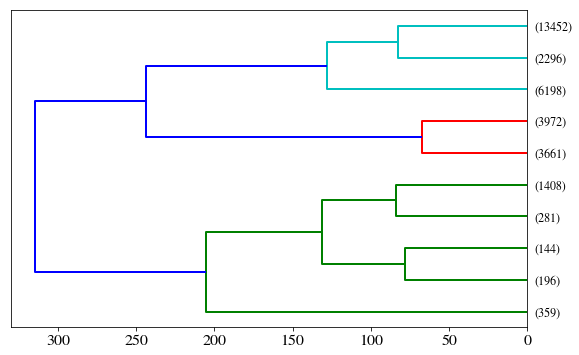

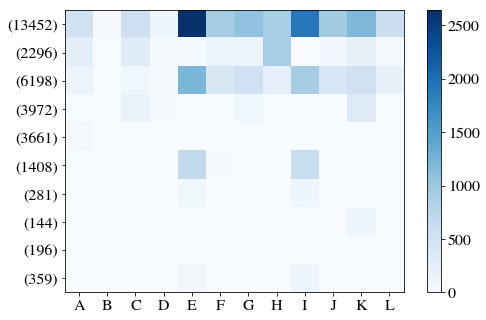

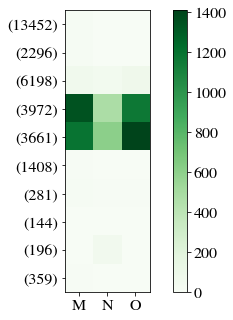

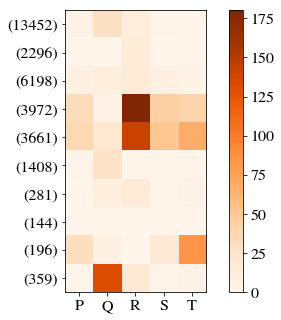

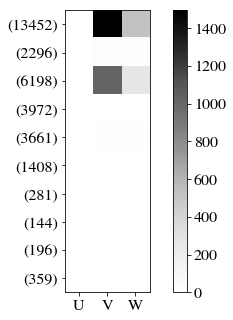

In [ ]:
plot_heat('2008', 65, 3)

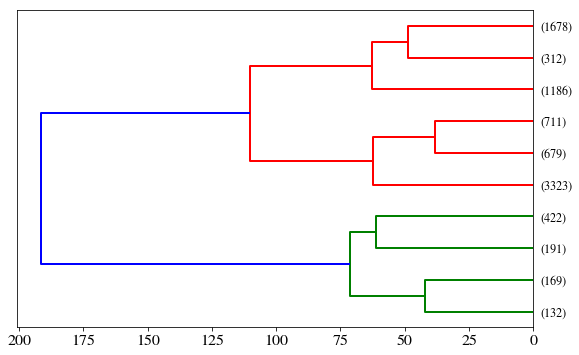

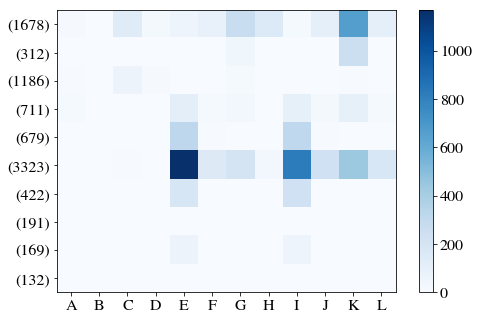

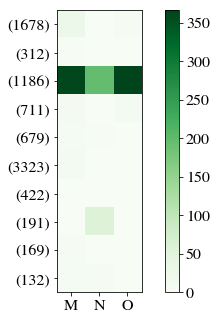

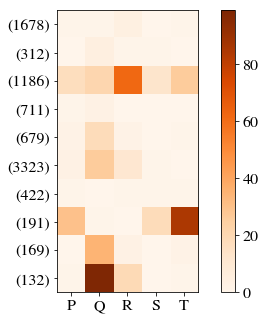

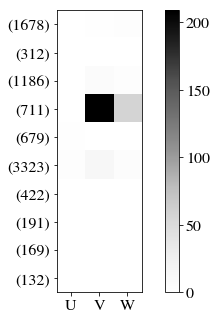

In [ ]:
plot_heat('2008', 81, 9)

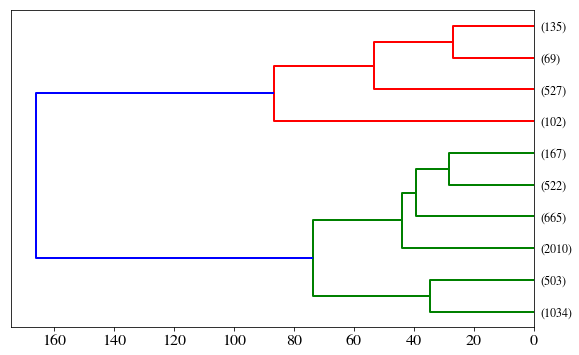

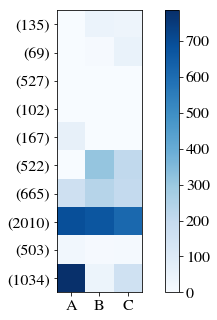

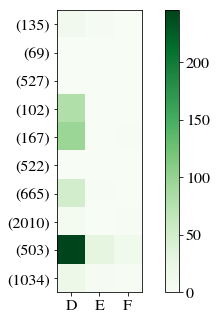

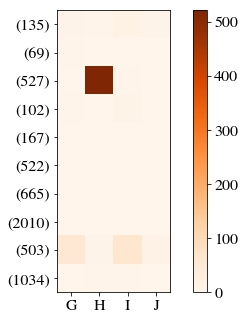

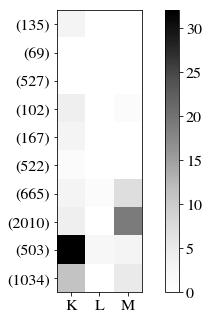

In [ ]:
plot_heat('2014', 65, 3)

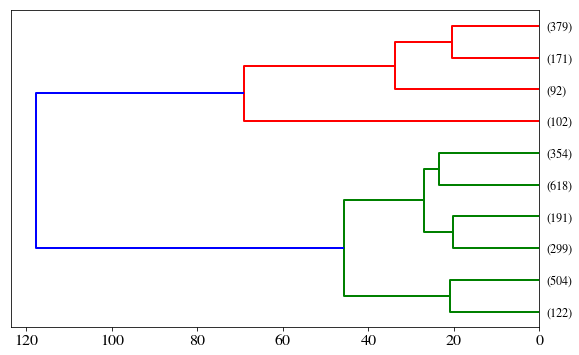

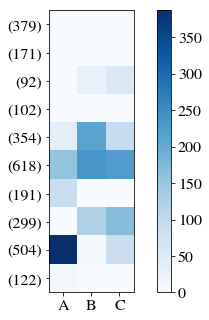

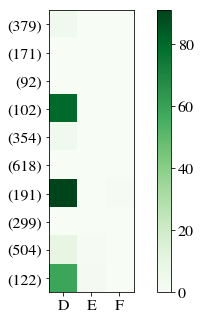

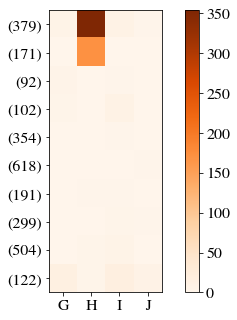

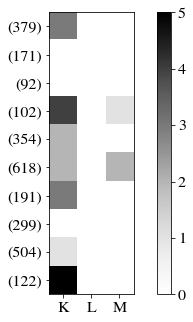

In [ ]:
plot_heat('2014', 81, 9)

## Matching matrices comparing with labels

In [ ]:
import numpy as np
import os
# figure out the worst and best for 2008 and 2014
AR_cur = [] # AR for current preparation
for d_set in ['2008', '2014']:
    AR = np.genfromtxt('AR_{}.csv'.format(d_set), delimiter=',')
    AR_cur.append(np.max(AR[65]))
    AR_cur.append(np.max(AR[81]))
AR_cur

[0.4829702447517002,
 0.276569659789828,
 0.46239172843334053,
 0.6192559495122347]

So the worst AR is for 2008, using 9$\sigma$ and the best is using 9$\sigma$ in 2014.
Lets get the matching matrices in either case

In [ ]:
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import calinski_harabaz_score, confusion_matrix

def get_M_from_labels(sub_dir, idx):
    df = load_data('data_{}.csv'.format(sub_dir))
    data, labels, _ = prepare(df, n_std = 9)
    link = load_linkage(sub_dir, idx)
    e = []
    for i in range(2,11):
        e.append(fcluster(link, i, 'maxclust'))
    e = np.array(e, 'int')

    # get CH
    CH = []
    for i, line in enumerate(e):
        CH.append(calinski_harabaz_score(data, e[i]))

    N = np.argmax(CH) + 2 # starts from 2

    M = confusion_matrix(e[np.argmax(CH)], np.array(labels, 'int'))
    return M

get_M_from_labels('2008', 81)

array([[ 547,   69,  298,    0],
       [6373,  991,  221,  304],
       [   0,    0,    0,    0],
       [   0,    0,    0,    0]], dtype=int64)

In [ ]:
get_M_from_labels('2014', 81)

array([[1835,  168,   70,   15],
       [   4,   80,   13,    5],
       [  85,    4,  550,    3],
       [   0,    0,    0,    0]], dtype=int64)

# Appendix C & Summary tables

We use the following code to produce the tables in appendix C. The table is tidied up manually using a spreadsheet package and the following tool is used to output the table into latex:
https://www.tablesgenerator.com/

In [ ]:
def get_appendix_table_C(subdirectory, n_std):
    # load the data frame
    df = load_data("data_{}.csv".format(subdirectory))

    data, labels, file_labels = prepare(df, logs = False, standardisation = None, n_std = n_std)

    # count by file label
    counts = data.groupby(file_labels).count()

    filelist = pd.read_csv("filelist_{}.csv".format(subdirectory))
    filelist = filelist[filelist['Label'] != 'F']


    # find the means and the standard deviations
    average = data.groupby(file_labels).mean().round(1)
    std = data.groupby(file_labels).std(ddof=0).round(1) 
    
    # include only samples which >  0 
    filelist = filelist.loc[average.index]
    
    # summary averages
    summary_averages = pd.DataFrame({
        "Label":filelist['Label'],
        'Sample':filelist['Short Name'],
        '$n>{}\sigma$'.format(n_std):counts['FL1_280'], 
        'statistic':['mean'] * len(counts),
        "FL1_280":average['FL1_280'],
        "FL2_280":average['FL2_280'],
        "FL2_370":average['FL2_370'],  
        "Size":average['Size'],
        "AF":average['AF']
    }
    )
    summary_std = pd.DataFrame({
        "Label":filelist['Label'],
        'Sample':filelist['Short Name'], 
        '$n>{}\sigma$'.format(n_std):[""] * len(counts),
        'statistic':['S. D.'] * len(counts),
        "FL1_280":std['FL1_280'],
        "FL2_280":std['FL2_280'],
        "FL2_370":std['FL2_370'],  
        "Size":std['Size'],
        "AF":std['AF']
    }
    )

    # combine
    summary = pd.concat([summary_averages, summary_std])
    return summary.sort_values(['Label', 'Sample', 'statistic'], ascending = [True, True, False])

In [ ]:
summary_2008_3 = get_appendix_table_C("2008", 3)
summary_2008_3.to_csv("2008_3_C.csv")
summary_2008_3

,Label,Sample,$n>3\sigma$,statistic,FL1_280,FL2_280,FL2_370,Size,AF
File_Label,,,,,,,,,
3.0,1,Bacillus Atrophaeus (unw),952,mean,94.6,63.9,65.4,1.4,7.7
3.0,1,Bacillus Atrophaeus (unw),,S. D.,47.3,36.1,44.6,0.4,3.8
4.0,1,"Bacillus Atrophaeus (unw, dil)",52,mean,110.3,51.8,43.0,1.3,8.1
4.0,1,"Bacillus Atrophaeus (unw, dil)",,S. D.,84.8,79.7,76.5,0.8,6.1
5.0,1,Bacillus Atrophaeus (w),1171,mean,164.2,60.6,48.5,1.7,9.3
5.0,1,Bacillus Atrophaeus (w),,S. D.,136.4,58.5,55.8,0.8,4.9
6.0,1,"Bacillus Atrophaeus (w, dil)",241,mean,140.7,50.3,46.1,1.7,9.4
6.0,1,"Bacillus Atrophaeus (w, dil)",,S. D.,97.9,57.1,58.4,0.8,5.9
7.0,1,Bacillus Atrophaeus Vegetative Cells (unw),4779,mean,239.3,221.2,192.0,1.1,4.7


In [ ]:
summary_2008_9 = get_appendix_table_C("2008", 9)
summary_2008_9.to_csv("2008_9_C.csv")
summary_2008_9

,Label,Sample,$n>9\sigma$,statistic,FL1_280,FL2_280,FL2_370,Size,AF
File_Label,,,,,,,,,
3.0,1,Bacillus Atrophaeus (unw),34,mean,214.2,142.5,163.3,2.2,10.2
3.0,1,Bacillus Atrophaeus (unw),,S. D.,79.3,60.2,72.9,0.6,5.6
4.0,1,"Bacillus Atrophaeus (unw, dil)",4,mean,230.8,259.2,242.5,2.7,14.4
4.0,1,"Bacillus Atrophaeus (unw, dil)",,S. D.,243.8,162.1,142.0,1.8,11.3
5.0,1,Bacillus Atrophaeus (w),217,mean,358.0,121.6,110.1,2.6,12.4
5.0,1,Bacillus Atrophaeus (w),,S. D.,218.1,105.4,95.5,1.1,6.1
6.0,1,"Bacillus Atrophaeus (w, dil)",38,mean,276.0,128.0,123.7,2.6,14.8
6.0,1,"Bacillus Atrophaeus (w, dil)",,S. D.,169.6,97.3,101.8,1.0,7.9
7.0,1,Bacillus Atrophaeus Vegetative Cells (unw),1915,mean,423.7,400.4,358.0,1.4,4.8


In [ ]:
summary_2014_3 = get_appendix_table_C("2014", 3)
summary_2014_3.to_csv("2014_3_C.csv")
summary_2014_3

,Label,Sample,$n>3\sigma$,statistic,FL1_280,FL2_280,FL2_370,Size,AF
File_Label,,,,,,,,,
6,1,Bacillus Atrophaeus (unwashed),1728,mean,104.5,45.5,26.5,1.2,8.4
6,1,Bacillus Atrophaeus (unwashed),,S. D.,118.0,45.9,61.2,0.4,4.3
10,1,Bacillus Atrophaeus (washed),1322,mean,25.4,211.2,357.0,1.2,5.0
10,1,Bacillus Atrophaeus (washed),,S. D.,69.5,222.7,376.5,0.5,2.1
11,1,E. coli (unwashed),1290,mean,104.3,174.9,317.4,1.3,6.1
11,1,E. coli (unwashed),,S. D.,187.3,207.1,395.6,0.6,2.8
5,2,Puffball I,504,mean,288.2,218.1,169.3,3.4,12.1
5,2,Puffball I,,S. D.,524.4,289.0,182.0,1.8,9.8
13,2,Puffball II,35,mean,-19.6,64.4,118.4,2.5,17.6


In [ ]:
summary_2014_9 = get_appendix_table_C("2014", 9)
summary_2014_9.to_csv("2014_9_C.csv")
summary_2014_9

,Label,Sample,$n>9\sigma$,statistic,FL1_280,FL2_280,FL2_370,Size,AF
File_Label,,,,,,,,,
6,1,Bacillus Atrophaeus (unwashed),684,mean,195.0,60.5,46.2,1.4,9.8
6,1,Bacillus Atrophaeus (unwashed),,S. D.,144.6,65.3,90.3,0.5,4.7
10,1,Bacillus Atrophaeus (washed),608,mean,65.4,358.7,636.8,1.6,4.6
10,1,Bacillus Atrophaeus (washed),,S. D.,83.6,257.9,402.1,0.5,2.0
11,1,E. coli (unwashed),632,mean,199.9,284.1,550.0,1.7,6.2
11,1,E. coli (unwashed),,S. D.,229.6,251.3,460.0,0.7,3.1
5,2,Puffball I,248,mean,599.7,380.6,252.3,4.3,8.7
5,2,Puffball I,,S. D.,606.0,341.3,226.1,1.8,8.2
13,2,Puffball II,3,mean,-20.7,176.7,417.3,2.4,19.7


## Condensing these tables down for the main text

In [ ]:
samples = summary_2008_3['Sample'][::2]
N_3 = summary_2008_3["$n>3\sigma$"][::2]
N_9 = summary_2008_9["$n>9\sigma$"][::2]
sample_labels = [i for i in string.ascii_uppercase[:len(samples)]]
condensed_summary_2008 = pd.DataFrame(
{
    'ID' : sample_labels,
    'Sample' : samples,
    '$n>3\sigma$' : N_3,
    '$n>9\sigma$' : N_9
})
condensed_summary_2008.to_csv("condensed_2008.csv")
condensed_summary_2008

,ID,Sample,$n>3\sigma$,$n>9\sigma$
File_Label,,,,
3.0,A,Bacillus Atrophaeus (unw),952,34
4.0,B,"Bacillus Atrophaeus (unw, dil)",52,4
5.0,C,Bacillus Atrophaeus (w),1171,217
6.0,D,"Bacillus Atrophaeus (w, dil)",241,38
7.0,E,Bacillus Atrophaeus Vegetative Cells (unw),4779,1915
8.0,F,"Bacillus Atrophaeus Vegetative Cells (unw, dil)",1488,264
9.0,G,Bacillus Atrophaeus Vegetative Cells (w),1884,573
10.0,H,"Bacillus Atrophaeus Vegetative Cells (w, dil)",2064,194
13.0,I,E coli. (unw),3684,1547


In [ ]:
samples = summary_2014_3['Sample'][::2]
N_3 = summary_2014_3["$n>3\sigma$"][::2]
N_9 = summary_2014_9["$n>9\sigma$"][::2]

# fix for nacl being zero when sig > 9 
N_9[12] = 0 # for nacl
N_9 = N_9.loc[N_3.index]

sample_labels = [i for i in string.ascii_uppercase[:len(samples)]]
condensed_summary_2014 = pd.DataFrame(
{
    'ID' : sample_labels,
    'Sample' : samples,
    '$n>3\sigma$' : N_3,
    '$n>9\sigma$' : N_9,
})
condensed_summary_2014.to_csv("condensed_2014.csv")
condensed_summary_2014

,ID,Sample,$n>3\sigma$,$n>9\sigma$
File_Label,,,,
6,A,Bacillus Atrophaeus (unwashed),1728,684
10,B,Bacillus Atrophaeus (washed),1322,608
11,C,E. coli (unwashed),1290,632
5,D,Puffball I,504,248
13,E,Puffball II,35,3
14,F,Puffball III,16,1
15,G,Aspen Pollen,74,31
4,H,Paper mulberry pollen,541,537
16,I,Poplar Pollen,104,50


# Gradient Boosting

In [ ]:
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingClassifier

def test_GB(data, labels):

    # split the data and labels in training and test data
    kf = KFold(n_splits = 5, shuffle = True)

    # classify and calculate the matching matrix
    n = len(np.unique(labels)) # number of unique groups
    M = np.zeros((n, n))

    data = np.array(data, 'float')
    labels = np.array(labels, 'int')
    pred_labels = np.zeros(shape = labels.shape)

    for train_idx, test_idx in kf.split(data):
        train_data = data[train_idx]
        test_data = data[test_idx]
        train_labels = labels[train_idx]
        test_labels = labels[test_idx]

        clf = GradientBoostingClassifier()
        clf.fit(train_data, train_labels)
        pred = clf.predict(test_data)

        pred_labels[test_idx] = pred

        for i in range(n):
            for j in range(n):
                M[i, j] += np.sum(test_labels[pred == i+1] == j+1)
    return pred_labels, M

In [ ]:
def test_all_GB(data_sub_dir):
    
    # previously we had an error where we set the fluorescence threshold 
    # to average + 0 std instead of not using a threshold at all
    # To reproduce this error comment out set the following instead
    #fl_list = [0, 3, 9]  # (INCORRECT)
    # the incorrect linkages are stored in a different folder
    
    fl_list = [None, 3, 9]
    
    # set up directories
    
    GB_dir = os.path.join(os.curdir, "GB")
    if not os.path.exists(GB_dir):
        os.mkdir(GB_dir)
        

    # run on different combinations
    t = 0
    AR = np.zeros((24,))
    
    t = 0
    for size_thr in [0, 0.8]:
        for fl_thr in fl_list:
            for logs in [True, False]:
                for standardisation in ['zscore', 'range']:
                    df = load_data('data_{}.csv'.format(data_sub_dir))
                    
                    # remove nfl from 2014 data
                    if data_sub_dir == '2014' and fl_thr != None:
                        df = df[df['Label'] != '4']
                    
                    data, labels, _ = prepare(df, size_thr, fl_thr, logs, standardisation, clip = False)

                    pred_labels, M = test_GB(data,labels)
                    AR[t] = adjusted_rand_score(pred_labels, labels)
                    print(size_thr, fl_thr, logs, standardisation, AR[t])  
                    t+=1
              
    ar_filename = os.path.join(GB_dir, "AR_{}".format(data_sub_dir))
    np.savetxt(ar_filename, AR, delimiter=',')

In [ ]:
for sub_dir in ['2008', '2014', 'PSL']:
    test_all_GB(sub_dir)

Not applying threshold
0 None True zscore 0.6564281290180319
Not applying threshold
0 None True range 0.6565377970356004
Not applying threshold
0 None False zscore 0.6568617434957501
Not applying threshold
0 None False range 0.6566415768184284
0 3 True zscore 0.8961712433731364
0 3 True range 0.8963492349325163
0 3 False zscore 0.8971325042046941
0 3 False range 0.896127995335579
0 9 True zscore 0.8842334102041508
0 9 True range 0.8822516742489771
0 9 False zscore 0.8817169874565562
0 9 False range 0.8838262780149321
Not applying threshold
0.8 None True zscore 0.7319659910452095
Not applying threshold
0.8 None True range 0.7321648810491176
Not applying threshold
0.8 None False zscore 0.7319233676737411
Not applying threshold
0.8 None False range 0.731550106591115
0.8 3 True zscore 0.8977067240096253
0.8 3 True range 0.8988911357902108
0.8 3 False zscore 0.8970258604760878
0.8 3 False range 0.8985839726898199
0.8 9 True zscore 0.8777243426594055
0.8 9 True range 0.8785163430247411
0.8 9

## Plot adjusted rand score

In [ ]:
# find out what columns correspond to 3 sig and 9 sigma etc.
t = 0 
combinations = []
for size_thr in [0, 0.8]:
    for fl_thr in fl_list:
        for logs in [True, False]:
            for standardisation in ['zscore', 'range']:
                r1 = size_thr == 0.8
                r2 = logs == True
                r3 = standardisation == 'zscore'
                
                if (r1 & r2 & r3):
                    if fl_thr == 3:
                        print(t)
                    elif fl_thr == 9:
                        print(t)
                combinations.append([size_thr, fl_thr, logs, standardisation])
                t += 1

16
20


In [ ]:
# get the bar heights
# row for each data set, column 3 sig, 9 sig and best
heights = np.zeros((3, 3)) 

GB_dir = os.path.join(os.curdir, "GB")

# for each of the datasets find the 3 sig AR score and 9 sig AR and the best
for i, d_set in enumerate(['PSL', '2008', '2014']):
    filename = os.path.join(GB_dir, "AR_{}".format(d_set))
    AR = np.genfromtxt(filename, delimiter=',')
    AR_3 = AR[16] # 3 sigma AR score
    AR_9 = AR[20] # 9 sigma AR score
    AR_best = np.max(AR)
    
    
    heights[i, 0] = AR_3
    heights[i, 1] = AR_9
    heights[i, 2] = AR_best
    
    print(d_set, combinations[np.argmax(AR)], AR_best)
heights

PSL [0.8, 9, False, 'range'] 0.9802619756974433
2008 [0.8, 3, True, 'range'] 0.8988911357902108
2014 [0, 9, True, 'zscore'] 0.9362872970468872


array([[0.97584975, 0.97923157, 0.98026198],
       [0.89770672, 0.87772434, 0.89889114],
       [0.91724792, 0.93474165, 0.9362873 ]])

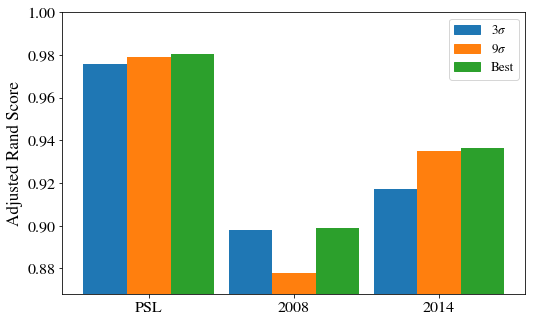

In [ ]:
import matplotlib.patches as m_patch

colors = ['#1f77b4', '#ff7f0e','#2ca02c']
fig, ax = plt.subplots()


fig.set_tight_layout(False)

for i in range(3):
    ax.bar(np.arange(3) + i * 0.3, heights[:, i], width = 0.3)
   


# set y limits
ax.set_ylim(np.min(heights)-0.01, 1)

# set labels
ax.set_ylabel('Adjusted Rand Score')

# set x labels
ax.set_xticks(np.arange(0.3, 3))
ax.set_xticklabels(['PSL', '2008', '2014'])

handles = []
for i, label in enumerate(['$3\sigma$', '$9\sigma$', 'Best']):
    patch = m_patch.Patch(color = colors[i], label = label)
    handles.append(patch)
plt.legend(handles = handles)
plt.savefig('GB.png', dpi = 600)

In [ ]:
# the worst scenario is in 2008 for 9 sigma, best case is in 2014 using 9 sigma

# get the worst
df = load_data('data_2008.csv')
data, labels, _ = prepare(df, n_std = 9)
_, M = test_GB(data, labels)

# save to file
filename = os.path.join(GB_dir, "2008_9_matching.csv")
np.savetxt(filename, np.array(M, 'int'), delimiter=',')
np.array(M, 'int')

array([[6854,   87,   79,    8],
       [  51,  898,  146,    4],
       [   8,   73,  290,    1],
       [   7,    2,    4,  291]])

In [ ]:
# and the best
df = load_data('data_2014.csv')
df = df[df['Label']!='4']
data, labels, _ = prepare(df, n_std = 9)
_, M = test_GB(data, labels)
np.array(M, 'int')

array([[1910,    6,   20],
       [  10,  214,   28],
       [   4,   32,  585]])

In [ ]:
import os
AR = np.genfromtxt(os.path.join(os.curdir, "GB", "AR_2008"),delimiter=',')
AR[20]

0.8777243426594055

In [ ]:
AR = np.genfromtxt(os.path.join(os.curdir, "GB", "AR_2014"),delimiter=',')
AR[20]

0.9347416514663646

# K means

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

for d_set in ['PSL', '2008', '2014']:
    df = load_data("data_{}.csv".format(d_set))
    

    AR = np.zeros((24, 10))
    t = 0 
    for size_thr in [0, 0.8]:
        for fl_thr in [None, 3, 9]:
            for logs in [True, False]:
                for standardisation in ['zscore', 'range']:
                    data, labels, _ = prepare(df, size_thr, fl_thr, logs, standardisation, clip = False)
                    for i in range(1, 11):
                        clf = KMeans(n_clusters=i)
                        clf.fit(data)
                        ar = adjusted_rand_score(clf.predict(data), labels)
                        AR[t, i-1] = ar
                    t += 1
    np.savetxt("AR_KM_{}.csv".format(d_set), AR, delimiter=',')
    print(np.max(AR))                

Not applying threshold
Not applying threshold
Not applying threshold
Not applying threshold
Not applying threshold
Not applying threshold
Not applying threshold
Not applying threshold
0.9644692500655634
Not applying threshold
Not applying threshold
Not applying threshold
Not applying threshold
Not applying threshold
Not applying threshold
Not applying threshold
Not applying threshold
0.508161666071954
Not applying threshold
Not applying threshold
Not applying threshold
Not applying threshold
Not applying threshold
Not applying threshold
Not applying threshold


In [ ]:
np.max(np.genfromtxt("AR_KM_2008.csv", delimiter=',')